In [22]:
import numpy as np
import cv2
import random
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import tkinter as tk
from tkinter import *
from tkinter import colorchooser
from tkinter import messagebox
from functools import partial
from sklearn.preprocessing import minmax_scale
from itertools import permutations
from tqdm import tqdm
from PIL import Image

In [24]:
class RecurrenceNN():
    
    def __init__(self,X,Y,h,n):
        self.input = X
        self.ground = Y
        self.hnodes = h
        self.inodes = np.size(self.input, 1)
        self.n_class = n
        
        #INITIALIZE THE PARAMETER WITH 0 MEAN AND 1 STD ...
        mean = 0
        std = 1
        
        # 4 WEIGHTS AND BIAS FOR LSTM LAYER ...
        self.w1 = np.random.normal(mean, std, (self.inodes+self.hnodes, self.hnodes))
        self.w2 = np.random.normal(mean, std, (self.inodes+self.hnodes, self.hnodes))
        self.w3 = np.random.normal(mean, std, (self.inodes+self.hnodes, self.hnodes))
        self.w4 = np.random.normal(mean, std, (self.inodes+self.hnodes, self.hnodes))
    
        self.b1 = np.random.normal(mean, std, self.hnodes)
        self.b2 = np.random.normal(mean, std, self.hnodes)
        self.b3 = np.random.normal(mean, std, self.hnodes)
        self.b4 = np.random.normal(mean, std, self.hnodes)

        # WEIGHT AND BIAS FOR OUTPUT-SOFTMAX LAYER ...
        self.w5 = np.random.normal(mean, std, (self.hnodes,self.n_class))
        self.b5 = np.random.normal(mean, std, self.n_class)
        # WEIGHTS AND BIAS PUT TOGETHER FOR EASY ACCESS
        self.weights = dict(w1=self.w1,w2=self.w2,w3=self.w3,w4=self.w4,w5=self.w5,b1=self.b1,b2=self.b2,b3=self.b3,b4=self.b4,b5=self.b5)
    
    def one_hot(self, y):
        le = LabelEncoder()
        target = le.fit_transform(y)
        y = np.eye(self.n_class)[target]
        return y
    
    def sigmoid(self,x):
        sigma = 1/(1 + np.exp(-x))
        return sigma
        
    def tanh(self,x,derivative=False):
        return (1 - np.square(np.tanh(x))) if derivative else np.tanh(x)
    
    def softmax(self,x):
        exp = np.exp(x)
        return exp/exp.sum(axis=1, keepdims=True)
    
    def crossEntropy(self, y_hat, y):
        cost = -np.sum(y*np.log(y_hat+1e-12))/len(y)
        return cost
    
    def unison_shuffle(self,x, y):
        assert len(x) == len(y)
        p = np.random.permutation(len(x))
        return x[p], y[p]
    
    def forget_gate(self, prev_ht, x):
        zt = np.hstack([prev_ht,x])
        af = (zt @ self.w1) + self.b1
        ft = self.sigmoid(af)
        return ft
    
    def input_gate(self, prev_ht, x):
        zt = np.hstack([prev_ht,x])
        ai = (zt @ self.w2) + self.b2
        ac = (zt @ self.w3) + self.b3
        it, gt = self.sigmoid(ai), self.tanh(ac)
        return it, gt
    
    def output_gate(self, prev_ht, x):
        zt = np.hstack([prev_ht,x])
        ao = (zt @ self.w4) + self.b4
        ot = self.sigmoid(ao)
        return ot
    
    def LSTM_cell(self, prev_ct, prev_ht, x):
        
        ft = self.forget_gate(prev_ht, x)
        it, gt = self.input_gate(prev_ht, x)
        ot = self.output_gate(prev_ht, x)
        ct = (prev_ct * ft) + (it * gt)
        ht = ot * self.tanh(ct)
        
        return ft, it, gt, ot, ct, ht
    
    def ZoneOut(self, x, prev_x, p):
        # DROPOUT AT PROBABILITY p ∈ (0,1] where p = 1 MEANS NO DROPOUT
        mask = np.random.binomial(1, p, size = x.shape)
        x = (mask * x) + ((1 - mask) * prev_x)
        return x
    
    def feedforward(self, X, p = 1, training = False, **kwargs):
        prev_ct = prev_ht = np.zeros(self.hnodes)
        fts, its, gts = np.empty((0,self.hnodes)), np.empty((0,self.hnodes)), np.empty((0,self.hnodes))
        ots, cts, hts = np.empty((0,self.hnodes)), np.empty((0,self.hnodes)), np.empty((0,self.hnodes))
        cts = np.vstack([cts, prev_ct])
        hts = np.vstack([hts, prev_ht])
        
        if training == True and 'target' in kwargs:
            for x in X:
                ft, it, gt, ot, ct, prev_ht = self.LSTM_cell(prev_ct, prev_ht, x)
                # DROPOUT APPLIED TO CELL STATE ONLY ; 0 <= p < 1 (DROPOUT) & p = 1 (NO DROPOUT)
                prev_ct = self.ZoneOut(ct, prev_ct, p)
                # ALL HYPERPARAMETERS GO TO 'CACHE'
                fts = np.vstack([fts, ft])
                its = np.vstack([its, it])
                gts = np.vstack([gts, gt])
                ots = np.vstack([ots, ot])
                cts = np.vstack([cts, prev_ct])
                hts = np.vstack([hts, prev_ht])

            z = (hts[1:,:] @ self.w5) + self.b5
            # WE ONLY NEED CELL STATES AND HIDDEN STATES FROM PREVIOUS STEPS
            cts, hts = np.delete(cts,-1,0), np.delete(hts,-1,0)
            # STORE ALL HYPERPARAMETERS IN CACHE TO USE IN BACKPROPAGATION
            cache = {'ft' : fts, 'it' : its, 'gt' : gts, 'ot' : ots, 'ct' : cts, 'ht' : hts}
            # PREDICTED PROBABILITY DISTRIBUTION
            y_hat = self.softmax(z)
            # TARGETED LABEL
            y = kwargs['target']
            # CROSS ENTROPY LOSS
            J = self.crossEntropy(y_hat, y)
            accuracy = sum(np.argmax(y, axis=1) == np.argmax(y_hat, axis=1))*100/len(y)
            return J, accuracy, y_hat, cache
        
        # This part of code is for validation
        elif 'target' in kwargs:
            for x in X:
                _, _, _, _, prev_ct, prev_ht = self.LSTM_cell(prev_ct, prev_ht,x)
                hts = np.vstack([hts, prev_ht])

            z = (hts[1:,:] @ self.w5) + self.b5
            y_hat = self.softmax(z)
            y = kwargs['target']
            J = self.crossEntropy(y_hat, y)
            accuracy = sum(np.argmax(y, axis=1) == np.argmax(y_hat, axis=1))*100/len(y)
            return J, accuracy
        
        # This part of code is for testing
        else:
            for x in tqdm(X, position = 0, desc = 'Progress', leave = False):
                _, _, _, _, prev_ct, prev_ht = self.LSTM_cell(prev_ct, prev_ht,x)
                hts = np.vstack([hts, prev_ht])

            z = (hts[1:,:] @ self.w5) + self.b5
            y_hat = self.softmax(z)
            return y_hat
    
    def clip_gradient_norm(self, grads, max_norm = 1):
    
        max_norm = float(max_norm)
        total_norm = 0
    
        # Calculate the L2 norm squared for each gradient and add them to the total norm
        for grad in grads.values():
            grad_norm = np.sum(np.power(grad, 2))
            total_norm += grad_norm
    
        total_norm = np.sqrt(total_norm)

        # Calculate clipping coeficient
        clip_coef = max_norm / (total_norm + 1e-8)

        # If the total norm is larger than the maximum allowable norm, then clip the gradient
        if clip_coef < 1:
            for k, v in grads.items():
                grads[k] = v*clip_coef

        return grads
    
    def Adam(self, factors, grads):
        for k1, k2 in zip(factors.keys(), grads.keys()):
            factors[k1][0] = (0.1 * grads[k2]) + (0.9 * factors[k1][0])
            factors[k1][1] = (0.001 * np.sum(np.power(grads[k2], 2))) + (0.999 * factors[k1][1])
        
        return factors
            
    def gradiants(self, x, y, prev_ct, prev_ht, d_next, ft, it, gt, ot, ct, ht, y_hat):
        
        zt = np.hstack([prev_ht, x])
        # Splited Gradiants due to cell state and hidden state
        dc_next, dh_next = d_next
        
        # Gradient of Loss w.r.t. cell state & hidden state
        dJ_dht = ((y_hat - y) @ self.w5.T) + dh_next
        dJ_dct = (ot * dJ_dht * self.tanh(ct, derivative=True)) + dc_next
        
        # Gradient of Loss w.r.t. forgate gate
        dJ_daf, daf_dw1 = np.atleast_2d(dJ_dct * prev_ct * ft * (1-ft)), np.atleast_2d(zt)
        dJ_dw1 = daf_dw1.T @ dJ_daf
        dJ_db1 = dJ_daf.flatten()
        dJ_dzt1 = dJ_daf @ self.w1.T
        
        # Gradient of Loss w.r.t. input gate
        dJ_dai, dai_dw2 = np.atleast_2d(dJ_dct * gt * it * (1 - it)), np.atleast_2d(zt)
        dJ_dw2 = dai_dw2.T @ dJ_dai
        dJ_db2 = dJ_dai.flatten()
        dJ_dzt2 = dJ_dai @ self.w2.T
        
        # Gradient of Loss w.r.t. candidate
        dJ_dac, dac_dw3 = np.atleast_2d(dJ_dct * it * (1 - np.square(gt))), np.atleast_2d(zt)       
        dJ_dw3 = dac_dw3.T @ dJ_dac
        dJ_db3 = dJ_dac.flatten()
        dJ_dzt3 = dJ_dac @ self.w3.T
        
        # Gradient of Loss w.r.t. output gate
        dJ_dao, dao_dw4 = np.atleast_2d(dJ_dht * self.tanh(ct) * ot * (1 - ot)), np.atleast_2d(zt)        
        dJ_dw4 = dao_dw4.T @ dJ_dao
        dJ_db4 = dJ_dao.flatten()
        dJ_dzt4 = dJ_dao @ self.w4.T
        
        # Gradient of Loss w.r.t. logits
        dJ_dz, dz_dw5 = np.atleast_2d(y_hat - y), np.atleast_2d(ht)
        dJ_dw5 = dz_dw5.T @ dJ_dz
        dJ_db5 = dJ_dz.flatten()
        
        # Split Gradients
        dJ_dzt = dJ_dzt1 + dJ_dzt2 + dJ_dzt3 + dJ_dzt4
        dh_next = dJ_dzt[:,:self.hnodes]
        dc_next = ft * dJ_dct
        d_next = (dc_next, dh_next)
        
        gradiants = dJ_dw1, dJ_dw2, dJ_dw3, dJ_dw4, dJ_dw5, dJ_db1, dJ_db2, dJ_db3, dJ_db4, dJ_db5
        grad = {'d'+k : v for k, v in zip(self.weights.keys(), gradiants)}
        
        return grad, d_next  
        
    def TrainNetwork(self, X, y, dropout):
        
        dc_next, dh_next = np.zeros(self.hnodes), np.zeros(self.hnodes)
        d_next = dc_next, dh_next
        grads = {'d'+k : np.zeros_like(v) for k, v in self.weights.items()}
        J, accuracy, y_hat, cache = self.feedforward(X, p = dropout, training = True, target=y)
        # MOVE BACKWARD IN TIMELINE
        for i in reversed(range(len(X))):
            grad, d_next = self.gradiants(X[i],y[i],cache['ct'][i],cache['ht'][i],d_next,cache['ft'][i],cache['it'][i],cache['gt'][i],cache['ot'][i],cache['ct'][i],cache['ht'][i],y_hat[i])
            # GRADINTS ADDED UP AFTER EACH ITERATION
            for k in grads.keys():
                grads[k] += grad[k]
        # AVERAGE OVER GRADIENTS
        for k, v in grads.items():
            grads[k] = v/len(X)
        # CLIPPING GRADINTS NORM TO AVOID EXPLODING GRADIENT PROBLEM   
        grads = self.clip_gradient_norm(grads)
        
        return grads, J, accuracy
    
    def backpropagation(self, X_validation, y_validation, dropout = 0.5, epoch = 1000, lr = 0.1):
        
        tr_Loss = []
        tr_Accuracy = []
        val_Loss = []
        val_Accuracy = []
        count = 0
        factors = {'f'+k : [0,0] for k in self.weights.keys()}
        
        for i in range(epoch):
            X_train, y_train = self.unison_shuffle(self.input, self.one_hot(self.ground))
            grads, tr_J, tr_accuracy = self.TrainNetwork(X_train, y_train, dropout)
            
            if i % 5 == 0:
                X_val, y_val = self.unison_shuffle(X_validation, self.one_hot(y_validation))
                val_J, val_accuracy = self.feedforward(X_val, target = y_val)
                # EARLY STOPPING IF VALIDATION ERROR INCREASES 3 TIMES SUCCESSIVELY
                if val_Loss and val_J > val_Loss[-1]:
                    count += 1
                    if count > 3:
                        print(".... STOPPED EARLY AS VALIDATION ERROR STARTS INCREASING ....\n .... TUNE YOUR LEARNING RATE AND TRY AGAIN ....")
                        break
                else:
                    count = 0
                print(f'Epoch -- {i}/{epoch} | Training_Loss-- {tr_J:1.3f} | Validation_Loss-- {val_J:1.3f} | Training_Accuracy-- {tr_accuracy:1.2f} | Validation_Accuracy-- {val_accuracy:1.2f}\n')
                
                
            dJ_dw1, dJ_db1 = grads['dw1'], grads['db1']
            dJ_dw2, dJ_db2 = grads['dw2'], grads['db2']  
            dJ_dw3, dJ_db3 = grads['dw3'], grads['db3']
            dJ_dw4, dJ_db4 = grads['dw4'], grads['db4']
            dJ_dw5, dJ_db5 = grads['dw5'], grads['db5']
            
            factors = self.Adam(factors, grads)
                
            # GRADIENT DESCENT FOR ADAM'S OPTIMIZATION
            self.w1 -= lr * factors['fw1'][0] / ((1 - 0.99**(i+1)) * (1e-8 + np.sqrt(factors['fw1'][1]/(1 - 0.999**(i+1)))))
            self.b1 -= lr * factors['fb1'][0] / ((1 - 0.99**(i+1)) * (1e-8 + np.sqrt(factors['fb1'][1]/(1 - 0.999**(i+1)))))
            
            self.w2 -= lr * factors['fw2'][0] / ((1 - 0.99**(i+1)) * (1e-8 + np.sqrt(factors['fw2'][1]/(1 - 0.999**(i+1)))))
            self.b2 -= lr * factors['fb2'][0] / ((1 - 0.99**(i+1)) * (1e-8 + np.sqrt(factors['fb2'][1]/(1 - 0.999**(i+1)))))
            
            self.w3 -= lr * factors['fw3'][0] / ((1 - 0.99**(i+1)) * (1e-8 + np.sqrt(factors['fw3'][1]/(1 - 0.999**(i+1)))))
            self.b3 -= lr * factors['fb3'][0] / ((1 - 0.99**(i+1)) * (1e-8 + np.sqrt(factors['fb3'][1]/(1 - 0.999**(i+1)))))
            
            self.w4 -= lr * factors['fw4'][0] / ((1 - 0.99**(i+1)) * (1e-8 + np.sqrt(factors['fw4'][1]/(1 - 0.999**(i+1)))))
            self.b4 -= lr * factors['fb4'][0] / ((1 - 0.99**(i+1)) * (1e-8 + np.sqrt(factors['fb4'][1]/(1 - 0.999**(i+1)))))
            
            self.w5 -= lr * factors['fw5'][0] / ((1 - 0.99**(i+1)) * (1e-8 + np.sqrt(factors['fw5'][1]/(1 - 0.999**(i+1)))))
            self.b5 -= lr * factors['fb5'][0] / ((1 - 0.99**(i+1)) * (1e-8 + np.sqrt(factors['fb5'][1]/(1 - 0.999**(i+1)))))
                
            tr_Loss.append(tr_J)
            tr_Accuracy.append(tr_accuracy)
            val_Loss.append(val_J)
            val_Accuracy.append(val_accuracy)
            
        return tr_Loss, tr_Accuracy, val_Loss, val_Accuracy

In [25]:
def create_feature(image):
    row, col, bands = np.shape(image)
    X = np.empty((row*col, 0))
    for i in range(bands):
        pixels = image[:,:,i].flatten().reshape(-1,1)
        X = np.hstack([X,pixels])
        
    X = minmax_scale(X)
        
    return X

def hiddenNeuron(X, n_class):
    Ns, Ni = np.shape(X)
    No = n_class
    while 1:
        alpha = int(input('Enter alpha value between 2 and 8 : '))
        if alpha not in range(2,9):
            print('Try Again...')
        else:
            break
            
    Nh = Ns/(alpha * (Ni + No))
    print(f'Number of hidden neurons is : {round(Nh)}')
    
    return round(Nh)

### TARGETED CLASSES

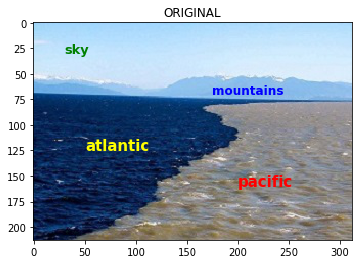

In [26]:
# IMAGE USED FOR CLASSIFICATION
image = mpimg.imread("AtlanticPacific.jpg")
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('ORIGINAL')
ax.text(50, 125, 'atlantic', color='yellow', fontsize=15, fontweight='bold')
ax.text(200, 160, 'pacific', color='red', fontsize=15, fontweight='bold')
ax.text(175, 70, 'mountains', color='blue', fontsize=12, fontweight='bold')
ax.text(30, 30, 'sky', color='green', fontsize=13, fontweight='bold')
plt.imshow(image)
plt.show()

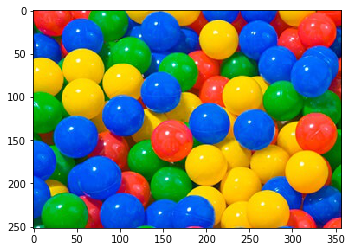

In [27]:
image2 = mpimg.imread("15631p.jpg")
plt.imshow(image2)
plt.show()

In [28]:
while True:
    try :
        n = int(input('Number of outputs classes : '))
        if n not in range(2,8) or not isinstance(n, int):
            print('Select an interger between 2 and 7')
        else:
            break
    except:
        print('Invalid. Try Again...')
        
classes = []
for i in range(n):
    c = input(f'Label for class-{i} : ')
    classes.append(c)
    
classes.sort()
print(classes)

Number of outputs classes : 4
Label for class-0 : pacific
Label for class-1 : atlantic
Label for class-2 : sky
Label for class-3 : mountains
['atlantic', 'mountains', 'pacific', 'sky']


### SELECT ROIs

In [6]:
window = Tk()
window.eval(f'tk::PlaceWindow {window.winfo_toplevel()} center')
window.withdraw()
messagebox.showinfo(title="How to select ROI",message="Draw rectangular box over the image.\nPress 'ENTER' to select a new ROI. \nPress 'ESCAPE' to select ROIs for the next class.\n\nNote : Draw smaller area for faster processing")
window.destroy()
window.quit()

#### TEST ROIs   ( NOTE : SELECT EXTREMLY SMALLER ROI FOR FASTER PROCESSING)

In [29]:
image = cv2.imread("AtlanticPacific.jpg")
row, column, bands = np.shape(image)
showCrosshair = False
fromCenter = False
Xtest_roi = np.empty((0,bands))
Ytest_roi = np.empty((0,1))

for i in range(len(classes)):
    roi = cv2.selectROIs(f'Select Roi for {classes[i]}', image, fromCenter, showCrosshair)
    clName = classes[i]
    for j in range(len(roi)):
        imCrop = image[int(roi[j][1]):int(roi[j][1]+roi[j][3]), int(roi[j][0]):int(roi[j][0]+roi[j][2])]
        r, c, b = np.shape(imCrop)
        pixel = create_feature(imCrop)
        label = np.array([clName]*r*c).reshape(-1,1)
        Xtest_roi = np.vstack([Xtest_roi, pixel])
        Ytest_roi = np.vstack([Ytest_roi, label])
        
cv2.destroyAllWindows()

#### VALIDATION ROIs  ( NOTE : SELECT EXTREMLY SMALLER ROI FOR FASTER PROCESSING)

In [30]:
Xval_roi = np.empty((0,bands))
Yval_roi = np.empty((0,1))

for i in range(len(classes)):
    roi = cv2.selectROIs(f'Select Roi for {classes[i]}', image, fromCenter, showCrosshair)
    clName = classes[i]
    for j in range(len(roi)):
        imCrop = image[int(roi[j][1]):int(roi[j][1]+roi[j][3]), int(roi[j][0]):int(roi[j][0]+roi[j][2])]
        r, c, b = np.shape(imCrop)
        pixel = create_feature(imCrop)
        label = np.array([clName]*r*c).reshape(-1,1)
        Xval_roi = np.vstack([Xval_roi, pixel])
        Yval_roi = np.vstack([Yval_roi, label])
        
cv2.destroyAllWindows()

### MODEL TRAINING WITH 0.5 DROPOUT

##### TRIAL AND ERROR FOR BEST NO. OF HIDDEN NUERONS

In [31]:
h = hiddenNeuron(Xtest_roi, len(classes))
# I have opted for 8

Enter alpha value between 2 and 8 : 8
Number of hidden neurons is : 14


In [32]:
lstmrnn = RecurrenceNN(Xtest_roi,Ytest_roi,h,len(classes))
tr_Loss,tr_Accuracy,val_Loss,val_Accuracy = lstmrnn.backpropagation(Xval_roi, Yval_roi, dropout = 0.5, epoch = 1000, lr = 0.1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch -- 0/1000 | Training_Loss-- 1.932 | Validation_Loss-- 1.523 | Training_Accuracy-- 28.80 | Validation_Accuracy-- 38.42

Epoch -- 5/1000 | Training_Loss-- 1.383 | Validation_Loss-- 1.217 | Training_Accuracy-- 32.10 | Validation_Accuracy-- 49.62

Epoch -- 10/1000 | Training_Loss-- 1.299 | Validation_Loss-- 1.307 | Training_Accuracy-- 33.69 | Validation_Accuracy-- 19.34

Epoch -- 15/1000 | Training_Loss-- 1.269 | Validation_Loss-- 1.233 | Training_Accuracy-- 48.61 | Validation_Accuracy-- 43.77

Epoch -- 20/1000 | Training_Loss-- 1.266 | Validation_Loss-- 1.172 | Training_Accuracy-- 37.25 | Validation_Accuracy-- 54.45

Epoch -- 25/1000 | Training_Loss-- 1.253 | Validation_Loss-- 1.209 | Training_Accuracy-- 46.90 | Validation_Accuracy-- 48.60

Epoch -- 30/1000 | Training_Loss-- 1.253 | Validation_Loss-- 1.227 | Training_Accuracy-- 49.67 | Validation_Accuracy-- 43.77

Epoch -- 35/1000 | Training_Loss-- 1.258 | Validation_Loss-- 1.187 | Training_Accuracy-- 40.29 | Validation_Accuracy-- 5

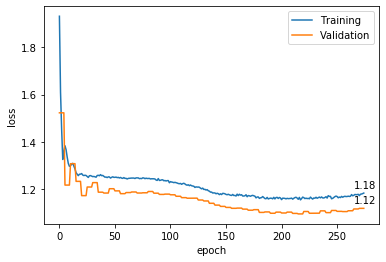

In [33]:
plt.plot(tr_Loss,label='Training')
plt.plot(val_Loss, label='Validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
for var in (tr_Loss, val_Loss):
    plt.annotate(f"{var[-1]:.2f}", xy=(1, var[-1]), xytext=(-25, 5), xycoords=('axes fraction', 'data'), textcoords='offset points')

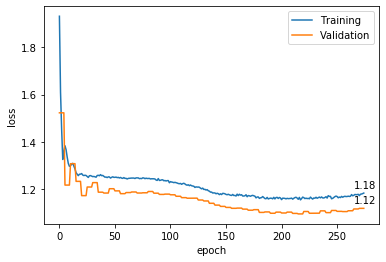

In [34]:
plt.plot(tr_Loss,label='Training')
plt.plot(val_Loss, label='Validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
for var in (tr_Loss, val_Loss):
    plt.annotate(f"{var[-1]:.2f}", xy=(1, var[-1]), xytext=(-25, 5), xycoords=('axes fraction', 'data'), textcoords='offset points')

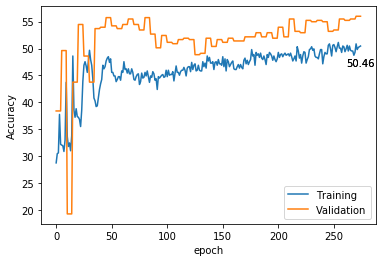

In [38]:
plt.plot(tr_Accuracy,label='Training')
plt.plot(val_Accuracy, label='Validation')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
for var in (tr_Accuracy, tr_Accuracy):
    plt.annotate(f"{var[-1]:.2f}", xy=(1, var[-1]), xytext=(-30, -20), xycoords=('axes fraction', 'data'), textcoords='offset points')

### CLASSIFICATION & VISUALISATION

In [39]:
X = create_feature(image)
y_hat = lstmrnn.feedforward(X)

In [40]:
window = Tk()
window.geometry('250x300')
    
class Button:
    def __init__(self, window, text, r):
        self.label = Label(window, width = 10, text = text, font = ('bold', 10))
        self.label.grid(row=r,column=2)
        self.btn = tk.Button(window, text='Pick a color',activebackground='red',width=10,command=partial(self.pick_color,colorDict))
        self.btn.grid(row=r,column=3)
        
    def pick_color(self,colorDict):
        while 1:
            color = colorchooser.askcolor()
            if color[0] in colorDict.values():
                messagebox.showinfo(title="Selection Error",message="This color is already selected\nTry a new color...",parent=window)
                
            else:   
                self.btn.config(bg=color[1])
                self.btn.config(text='')
                self.btn.config(width=3)
                colorDict[self.label['text']] = color[0]
                break

r = 2
colorDict = {}
for i in range(len(classes)):
    btn = Button(window, classes[i], r)
    r += 2

col_count, row_count = window.grid_size()
for row in range(row_count):
    window.grid_rowconfigure(row, minsize=10)

for col in range(col_count):
    window.grid_columnconfigure(col, minsize=10)
    
window.mainloop()
print(f'Your choosen colors in (R,G,B) :\n\n{colorDict}')

Your choosen colors in (R,G,B) :

{'atlantic': (0.0, 128.5, 255.99609375), 'mountains': (128.5, 255.99609375, 128.5), 'pacific': (128.5, 255.99609375, 255.99609375), 'sky': (232.90625, 232.90625, 232.90625)}


In [41]:
colorList = list(colorDict.values())
row, column, _ = np.shape(image)
labels = np.argmax(y_hat, axis=1).reshape(row, column)
imgArray = np.zeros([row, column, 3], dtype=np.uint8)
for i in range(row):
    for j in range(column):
        rgb = labels[i,j]
        imgArray[i,j] = colorList[rgb]

img = Image.fromarray(imgArray)

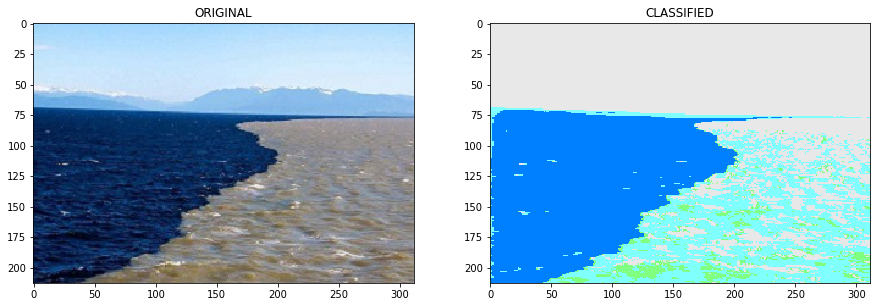

In [42]:
image = mpimg.imread("AtlanticPacific.jpg")
fig = plt.figure(figsize=(15,10))
fig.add_subplot(121).set_title('ORIGINAL')
plt.imshow(image)
fig.add_subplot(122).set_title('CLASSIFIED')
plt.imshow(img)
plt.show()